In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from sklearn.model_selection import train_test_split

# Load the data
df = pd.read_csv("23_24_match_details.csv", sep=",")

# Define comprehensive team name variations
team_variations = {
    "Team_1": ["Arsenal"],
    "Team_2": ["Aston Villa"],
    "Team_3": ["Bournemouth"],
    "Team_4": ["Brentford"],
    "Team_5": ["Brighton & Hove Albion", "Brighton"],
    "Team_6": ["Burnley"],
    "Team_7": ["Chelsea"],
    "Team_8": ["Crystal Palace"],
    "Team_9": ["Everton"],
    "Team_10": ["Fulham"],
    "Team_11": ["Liverpool"],
    "Team_12": ["Luton Town"],
    "Team_13": ["Manchester City", "Man City"],
    "Team_14": ["Manchester United"],
    "Team_15": ["Newcastle United", "Newcastle"],
    "Team_16": ["Nottingham Forest"],
    "Team_17": ["Sheffield United"],
    "Team_18": ["Tottenham Hotspur", "Tottenham"],
    "Team_19": ["West Ham United", "West Ham"],
    "Team_20": ["Wolves"],
}

# Create a reverse mapping dictionary with lowercase keys for case-insensitive matching
mask_mapping = {}
for team_label, variations in team_variations.items():
    for name in variations:
        mask_mapping[name.lower()] = team_label

# Function to replace team names in text with their masked counterparts
def mask_teams(text, mapping):
    if pd.isnull(text):
        return text
    sorted_teams = sorted(mapping.keys(), key=len, reverse=True)
    for team in sorted_teams:
        pattern = r"\b" + re.escape(team) + r"(?:'s)?\b"
        replacement = mapping[team]
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    return text

# Apply masking to 'Home' and 'Away' columns
if "Home" in df.columns:
    df["Home_Masked"] = df["Home"].str.lower().map(mask_mapping)
else:
    df["Home_Masked"] = np.nan

if "Away" in df.columns:
    df["Away_Masked"] = df["Away"].str.lower().map(mask_mapping)
else:
    df["Away_Masked"] = np.nan

# Apply masking to 'events' and 'summary' columns
if "events" in df.columns:
    df["text_Masked"] = df["events"].apply(lambda x: mask_teams(x, mask_mapping))
else:
    df["text_Masked"] = np.nan

# Define binary event functions
def red_card_followed_by_goal(text):
    """Check if there was a red card followed by a goal."""
    if pd.isnull(text): return 0
    if re.search(r"red card.*?goal", text, re.IGNORECASE | re.DOTALL):
        return 1
    return 0

def last_minute_goal(text):
    """Check if a goal was scored in the last minute or extra time."""
    if pd.isnull(text): return 0
    if re.search(r"goal.*?(90'|extra time)", text, re.IGNORECASE):
        return 1
    return 0

def comeback_attempt(text):
    """Check if there was an attempt to come back (team scores after being down)."""
    if pd.isnull(text): return 0
    if re.search(r"down.*?goal", text, re.IGNORECASE | re.DOTALL):
        return 1
    return 0

def var_review_red_card(text):
    """Check if a VAR review led to a red card."""
    if pd.isnull(text): return 0
    if re.search(r"VAR review.*?red card", text, re.IGNORECASE | re.DOTALL):
        return 1
    return 0

def hat_trick(text):
    """Check if there was a hat-trick."""
    if pd.isnull(text): return 0
    if re.search(r"hat[- ]trick", text, re.IGNORECASE):
        return 1
    return 0

def penalty_drama(text):
    """Check if there was a missed or contested penalty."""
    if pd.isnull(text): return 0
    if re.search(r"penalty.*?(missed|saved|contested)", text, re.IGNORECASE):
        return 1
    return 0

# Apply the binary event functions
if "text_Masked" in df.columns:
    df["Red_Card_Followed_By_Goal"] = df["text_Masked"].apply(red_card_followed_by_goal)
    df["Last_Minute_Goal"] = df["text_Masked"].apply(last_minute_goal)
    df["Comeback_Attempt"] = df["text_Masked"].apply(comeback_attempt)
    df["VAR_Review_Red_Card"] = df["text_Masked"].apply(var_review_red_card)
    df["Hat_Trick"] = df["text_Masked"].apply(hat_trick)
    df["Penalty_Drama"] = df["text_Masked"].apply(penalty_drama)
else:
    df["Red_Card_Followed_By_Goal"] = 0
    df["Last_Minute_Goal"] = 0
    df["Comeback_Attempt"] = 0
    df["VAR_Review_Red_Card"] = 0
    df["Hat_Trick"] = 0
    df["Penalty_Drama"] = 0

# Calculate overall excitement score by summing the binary event columns
df["Excitement_Score"] = (
    df["Red_Card_Followed_By_Goal"] +
    df["Last_Minute_Goal"] +
    df["Comeback_Attempt"] +
    df["VAR_Review_Red_Card"] +
    df["Hat_Trick"] +
    df["Penalty_Drama"]
)

# Label excitement level based on score threshold
def label_excitement(score):
    if score >= 2:
        return "Exciting"
    else:
        return "Normal"

df["Excitement_Label"] = df["Excitement_Score"].apply(label_excitement)

# Rename columns to prepare for tokenization and processing
df.rename(columns={"id": "textid", "text_Masked": "text", "Excitement_Label": "label"}, inplace=True)

# Ensure all text inputs are strings and create nested list structure
df["text"] = df["text"].fillna("").astype(str)  # Ensure all text is string
df["text"] = df["text"].apply(lambda x: [x])  # Convert to nested list format

# Split the data into training (80%) and temp (20%)
train_data, temp_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

# Split the temp data into validation (10%) and test (10%)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data["label"])

# Check the distribution of labels in each split
print("\nDistribution of Excitement Levels:")
print("Training Set:")
print(train_data["label"].value_counts(normalize=True))
print("\nValidation Set:")
print(validation_data["label"].value_counts(normalize=True))
print("\nTest Set:")
print(test_data["label"].value_counts(normalize=True))

# Save each split to separate files
train_data.to_csv("train_data.tsv", sep="\t", index=False)
validation_data.to_csv("validation_data.tsv", sep="\t", index=False)
test_data.to_csv("test_data.tsv", sep="\t", index=False)

print("\nData has been split and saved into the following files:")
print("1. Training Data: train_data.tsv")
print("2. Validation Data: validation_data.tsv")
print("3. Test Data: test_data.tsv")


Distribution of Excitement Levels:
Training Set:
label
Normal      0.640496
Exciting    0.359504
Name: proportion, dtype: float64

Validation Set:
label
Normal      0.633333
Exciting    0.366667
Name: proportion, dtype: float64

Test Set:
label
Normal      0.645161
Exciting    0.354839
Name: proportion, dtype: float64

Data has been split and saved into the following files:
1. Training Data: train_data.tsv
2. Validation Data: validation_data.tsv
3. Test Data: test_data.tsv


In [ ]:
import pandas as pd
import numpy as np
import re

# Load the data
input_file = '../data/clean_comm_data.csv'
df = pd.read_csv(input_file)

# Define comprehensive team name variations
team_variations = {
    "Team_1": ["Arsenal", "Gunners"],
    "Team_2": ["Aston Villa", "Villa", "Villans", "The Lions", "Claret and Blue Army"],
    "Team_3": ["Bournemouth", "Cherries"],
    "Team_4": ["Brentford", "Bees"],
    "Team_5": ["Brighton & Hove Albion", "Brighton", "Seagulls", "Albion"],
    "Team_6": ["Burnley", "Clarets"],
    "Team_7": ["Chelsea", "Blues"],
    "Team_8": ["Crystal Palace", "Eagles"],
    "Team_9": ["Everton", "Toffees"],
    "Team_10": ["Fulham", "The Cottagers", "Whites", "Lily Whites"],
    "Team_11": ["Liverpool", "Reds"],
    "Team_12": ["Luton Town", "Hatters"],
    "Team_13": ["Manchester City", "Man City", "City", "Citizens", "Sky Blues"],
    "Team_14": ["Manchester United", "Man United", "Man U", "Red Devils", "United"],
    "Team_15": ["Newcastle United", "Newcastle", "Magpies", "Geordies"],
    "Team_16": ["Nottingham Forest", "Forest", "Reds", "Tricky Trees", "Garibaldi"],
    "Team_17": ["Sheffield United", "Blades"],
    "Team_18": ["Tottenham Hotspur", "Tottenham", "Spurs", "Lilywhites"],
    "Team_19": ["West Ham United", "West Ham", "Hammers", "Irons"],
    "Team_20": ["Wolves", "Wolverhampton Wanderers", "Wanderers"]
}

# Create a reverse mapping dictionary with lowercase keys for case-insensitive matching
mask_mapping = {}
for team_label, variations in team_variations.items():
    for name in variations:
        mask_mapping[name.lower()] = team_label

# Function to replace team names in text with their masked counterparts
def mask_teams(text, mapping):
    if pd.isnull(text):
        return text
    sorted_teams = sorted(mapping.keys(), key=len, reverse=True)
    for team in sorted_teams:
        pattern = r"\b" + re.escape(team) + r"(?:'s)?\b"
        replacement = mapping[team]
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    return text

# Apply masking to 'Home' and 'Away' columns
if "Home" in df.columns:
    df["Home_Masked"] = df["Home"].str.lower().map(mask_mapping)
else:
    df["Home_Masked"] = np.nan

if "Away" in df.columns:
    df["Away_Masked"] = df["Away"].str.lower().map(mask_mapping)
else:
    df["Away_Masked"] = np.nan

# Apply masking to 'events' and 'summary' columns
if "events" in df.columns:
    df["text_Masked"] = df["events"].apply(lambda x: mask_teams(x, mask_mapping))
else:
    df["text_Masked"] = np.nan

# Define binary event functions
def red_card_followed_by_goal(text):
    if pd.isnull(text): return 0
    if re.search(r"red card.*?goal", text, re.IGNORECASE | re.DOTALL):
        return 1
    return 0

def last_minute_goal(text):
    if pd.isnull(text): return 0
    if re.search(r"goal.*?(90'|extra time)", text, re.IGNORECASE):
        return 1
    return 0

def comeback_attempt(text):
    if pd.isnull(text): return 0
    if re.search(r"down.*?goal", text, re.IGNORECASE | re.DOTALL):
        return 1
    return 0

def var_review_red_card(text):
    if pd.isnull(text): return 0
    if re.search(r"VAR review.*?red card", text, re.IGNORECASE | re.DOTALL):
        return 1
    return 0

def hat_trick(text):
    if pd.isnull(text): return 0
    if re.search(r"hat[- ]trick", text, re.IGNORECASE):
        return 1
    return 0

def penalty_drama(text):
    if pd.isnull(text): return 0
    if re.search(r"penalty.*?(missed|saved|contested)", text, re.IGNORECASE):
        return 1
    return 0

# Apply the binary event functions
if "text_Masked" in df.columns:
    df["Red_Card_Followed_By_Goal"] = df["text_Masked"].apply(red_card_followed_by_goal)
    df["Last_Minute_Goal"] = df["text_Masked"].apply(last_minute_goal)
    df["Comeback_Attempt"] = df["text_Masked"].apply(comeback_attempt)
    df["VAR_Review_Red_Card"] = df["text_Masked"].apply(var_review_red_card)
    df["Hat_Trick"] = df["text_Masked"].apply(hat_trick)
    df["Penalty_Drama"] = df["text_Masked"].apply(penalty_drama)
else:
    df["Red_Card_Followed_By_Goal"] = 0
    df["Last_Minute_Goal"] = 0
    df["Comeback_Attempt"] = 0
    df["VAR_Review_Red_Card"] = 0
    df["Hat_Trick"] = 0
    df["Penalty_Drama"] = 0

# Calculate overall excitement score by summing the binary event columns
df["Excitement_Score"] = (
    df["Red_Card_Followed_By_Goal"] +
    df["Last_Minute_Goal"] +
    df["Comeback_Attempt"] +
    df["VAR_Review_Red_Card"] +
    df["Hat_Trick"] +
    df["Penalty_Drama"]
)

# Label excitement level based on score threshold
def label_excitement(score):
    if score >= 2:
        return "Exciting"
    else:
        return "Normal"

df["Excitement_Label"] = df["Excitement_Score"].apply(label_excitement)

# Rename columns to prepare for tokenization and processing
df.rename(columns={"id": "textid", "text_Masked": "text", "Excitement_Label": "label"}, inplace=True)

# Ensure all text inputs are strings
df["text"] = df["text"].fillna("").astype(str)  # Ensure all text is string

# Define the function to split text
# Assumption: The dataframe has columns 'textid' and 'text'
# For rows where 'text' has more than 400 words, split it into multiple rows
def split_text(row, word_limit=400):
    words = row['text'].split()
    chunks = [words[i:i + word_limit] for i in range(0, len(words), word_limit)]
    result_rows = []
    for index, chunk in enumerate(chunks):
        result_row = row.copy()
        result_row['text'] = ' '.join(chunk)
        if index > 0:
            result_row['textid'] = f"{row['textid']}_{index + 1}"
        result_rows.append(result_row)
    return result_rows

# Create a new dataframe to hold the split rows
split_rows = []
for _, row in df.iterrows():
    split_rows.extend(split_text(row))

# Create a new DataFrame
new_df = pd.DataFrame(split_rows)

# # Save the new DataFrame
# output_file = '../data/split_comm_data.csv'
# new_df.to_csv(output_file, index=False)

print("Splitting completed. Output saved to 'split_comm_data.csv'")




Splitting completed. Output saved to 'split_comm_data.csv'


In [6]:
from sklearn.model_selection import train_test_split

# Split the data into train (70%), validation (15%), and test (15%)
train_df, temp_df = train_test_split(new_df, test_size=0.3, random_state=42)
validate_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Save train, validate, and test sets as .tsv files
train_df = train_df[['textid', 'text', 'Excitement_Score', 'label']]
validate_df = validate_df[['textid', 'text', 'Excitement_Score', 'label']]
test_df = test_df[['textid', 'text', 'label']]

# Rename columns for test_df and add 'condition' column
test_df.rename(columns={'label': 'target'}, inplace=True)
test_df['condition'] = 'commentary'

# Save the dataframes to .tsv files
train_df.to_csv('../data/split_comm_data_train.tsv', sep='\t', index=False)
validate_df.to_csv('../data/split_comm_data_validate.tsv', sep='\t', index=False)
test_df.to_csv('../data/split_comm_data_test.tsv', sep='\t', index=False)

print("Data splitting into train, validate, and test sets completed. Output saved to respective .tsv files.")

Data splitting into train, validate, and test sets completed. Output saved to respective .tsv files.


Accuracy: 0.63
Precision: 0.61
Recall: 0.63
F1 Score: 0.61
Confusion Matrix:
[[186  47]
 [ 87  44]]


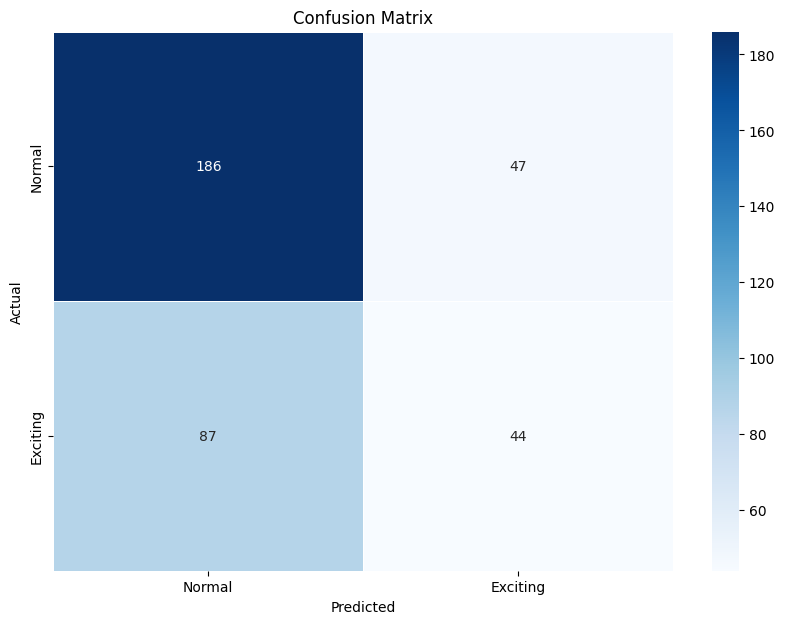

In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
input_file = '../predictions/preds3.tsv'
df = pd.read_csv(input_file, sep='\t')

# Check if required columns exist
required_columns = {'target', 'predicted'}
missing_columns = required_columns - set(df.columns)
if missing_columns:
    print(f"Error: Missing columns in the input file: {missing_columns}")
    raise SystemExit(1)

# Calculate metrics
accuracy = accuracy_score(df['target'], df['predicted'])
precision = precision_score(df['target'], df['predicted'], average='weighted')
recall = recall_score(df['target'], df['predicted'], average='weighted')
f1 = f1_score(df['target'], df['predicted'], average='weighted')

# Calculate confusion matrix
labels = ['Normal', 'Exciting']
conf_matrix = confusion_matrix(df['target'], df['predicted'], labels=labels)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=.5, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
